# Import libraries

In [155]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import statistics 
from scipy.stats import mode 
import scipy 
from mlxtend.preprocessing import TransactionEncoder 
import seaborn as sns

In [156]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Import data

In [157]:
import scipy.io
dataset = scipy.io.loadmat('baroAccSonarData.mat')

In [158]:
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Mar 10 16:07:48 2021',
 '__version__': '1.0',
 '__globals__': [],
 'accMeasure': array([[ 0.00249344],
        [ 0.00164948],
        [-0.00178101],
        ...,
        [-0.00714144],
        [-0.00620341],
        [ 0.00156962]]),
 'baroMeasure': array([[-0.04565712],
        [-0.06209983],
        [-0.03115329],
        ...,
        [ 2.5304051 ],
        [ 2.5154895 ],
        [ 2.3941607 ]]),
 'hTrue': array([[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.99975198],
        [1.99975368],
        [1.99975282]]),
 'sonarMeasure': array([[-0.02622557],
        [-0.02429315],
        [-0.02070862],
        ...,
        [ 1.98939554],
        [ 2.00779838],
        [ 1.99216615]]),
 't': array([[0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 5.9998e+02, 5.9999e+02,
         6.0000e+02]])}

In [159]:
accMeasure = dataset['accMeasure'].tolist()
baroMeasure = dataset['baroMeasure'].tolist()
sonarMeasure = dataset['sonarMeasure'].tolist()
hTrue = dataset['hTrue'].tolist()
t = dataset['t'].tolist()

In [160]:
accMeasure = list(np.concatenate(accMeasure).flat)
baroMeasure = list(np.concatenate(baroMeasure).flat)
sonarMeasure = list(np.concatenate(sonarMeasure).flat)
hTrue = list(np.concatenate(hTrue).flat)
t = list(np.concatenate(t).flat)

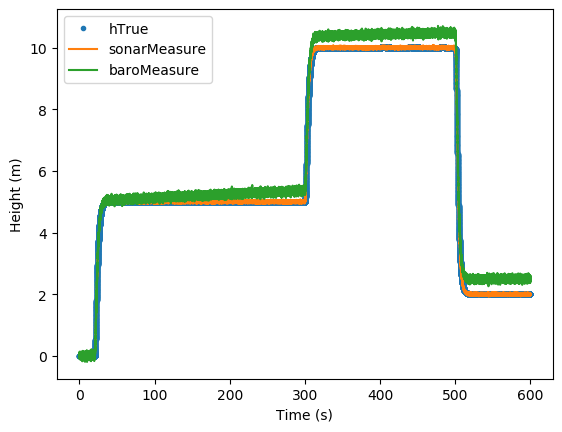

In [161]:
plt.plot(t, hTrue, '.',label='hTrue')
plt.plot(t, sonarMeasure, label='sonarMeasure')
plt.plot(t, baroMeasure, label='baroMeasure',)
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.savefig('Overall height 1.png', transparent=True)

plt.show()

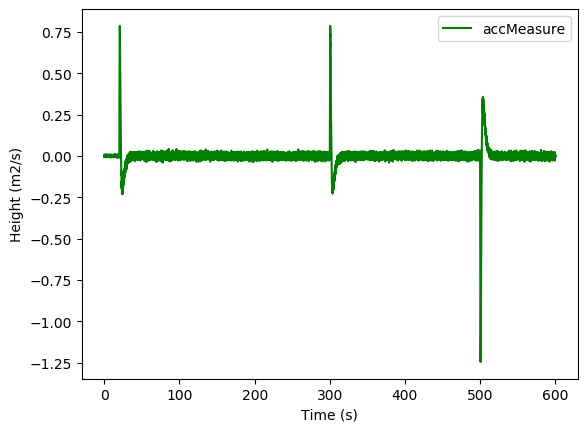

0.0747658330847698

In [162]:
#plt.plot(t, hTrue, '.',label='hTrue')
#plt.plot(t[:2000], sonarMeasure[:2000], label='sonarMeasure')
plt.plot(t, accMeasure, 'g', label='accMeasure',)
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Height (m2/s)')

plt.savefig('Acceleration.png', transparent=True)

plt.show()

np.std(accMeasure)

In [163]:
σ_barometer = np.std(baroMeasure[:2000])
σ_sonar = np.std(sonarMeasure[:2000])
σ_acceleration = np.std(accMeasure[:2000])

print(σ_barometer, σ_sonar, σ_acceleration)

0.055410633630651095 0.019942271881281115 0.0030197653111781854


# Question 1

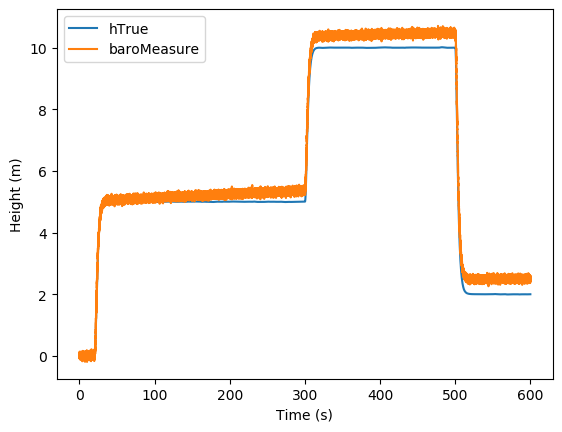

In [164]:
plt.plot(t, hTrue, label='hTrue')
plt.plot(t, baroMeasure, label='baroMeasure',)
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.savefig('Overall height 2.png', transparent=True)

plt.show()

## Functions

In [165]:
def state_extrap(F, xo, B, u):        #The State Extrapolation Equation
    
    x = np.dot(F, xo) + np.dot(B, u)
    
    return x

In [166]:
def cov_extrap(F, p, Q):            #The Covariance Extrapolation Equation
    
    p = np.dot(np.dot(F, p), np.transpose(F)) + Q
    
    return p

In [167]:
def gain(po, H, rn):              #The Kalman Gain
    
    Kn = np.dot(np.dot(po, np.transpose(H)),np.linalg.inv((np.dot(np.dot(H , po), np.transpose(H)) + rn)))
    
    return Kn

In [168]:
def state_update(xo, Kn, zn, H):    #The State Update Equation
    
    xn = xo + np.dot(Kn, (zn - np.dot(H, xo)))
    
    return xn

In [169]:
def cov_update(I, Kn, H, po, rn):   #The Covariance Update Equation
    
    pn = np.dot(np.dot((I - np.dot(Kn,H)),po),np.transpose(I - np.dot(Kn,H))) + np.dot(np.dot(Kn, rn), np.transpose(Kn))
    
    return pn

## Initialise variables

In [170]:
σbarometer = 0.056                     #barometer measurement error standard deviation
σacceleration = 0.003                  #accelerometer measurement error standard deviation
ϵacceleration = 1.25                   #accelerometer error 

In [171]:
T = 0.01                               #Time step between measurements

xo = [[0],                             #initial System State guess
     [0]]

po = [[100, 0],                        #initial uncertainty estimate guess
      [0, 100]]

F = [[1, T],                           #State transition matrix
    [0, 1]]

H = [[1, 0]]                           #Observation matrix

Qo = [[(T**4)/4, (T**3)/2],            #Process noise matrix
    [(T**3)/2, T**2]]

Q = np.dot(Qo, (ϵacceleration*T)**2)

rn = [[σbarometer**2]]                 #Measurement uncertainty

I = [[1, 0],                           #Identity matrix
    [0, 1]]

B = [[0.5 * (T**2)],                    #Control matrix
    [T]]

u0 = 0                                  #initial acceleration

## General code

In [172]:
Position = []
Velocity = []
Kalman_Gain = []

xo = state_extrap(F, xo, B, u0)
po = cov_extrap(F, po, Q)

for i in range(len(hTrue)):
    
    zn = baroMeasure[i]
    u = accMeasure[i]
    
    un = u + σacceleration**2

    Kn = gain(po, H, rn)
    Kalman_Gain.append(Kn[0].item())
    
    x = state_update(xo, Kn, zn, H)
    p = cov_update(I, Kn, H, po, rn)
        
    xo = state_extrap(F, x, B, un)
    po = cov_extrap(F, p, Q)
    
    Position.append(xo[0].item())
    Velocity.append(xo[1].item())

## graphs

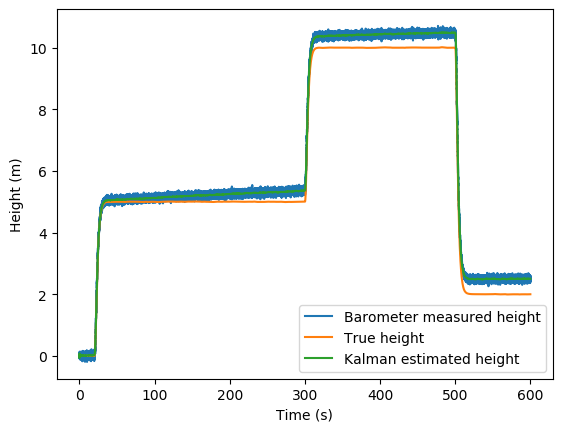

In [173]:
plt.plot(t, baroMeasure, label='Barometer measured height')
plt.plot(t, hTrue, label='True height')
plt.plot(t, Position, label='Kalman estimated height')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.savefig('Q1 height.png', transparent=True)

plt.show()

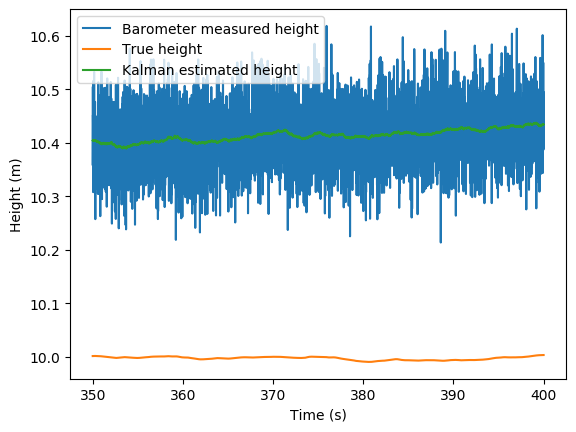

In [174]:
plt.plot(t[35000:40000], baroMeasure[35000:40000], label='Barometer measured height')
plt.plot(t[35000:40000], hTrue[35000:40000], label='True height')
plt.plot(t[35000:40000], Position[35000:40000], label='Kalman estimated height')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

#plt.savefig('Q1 height.png', transparent=True)

plt.show()

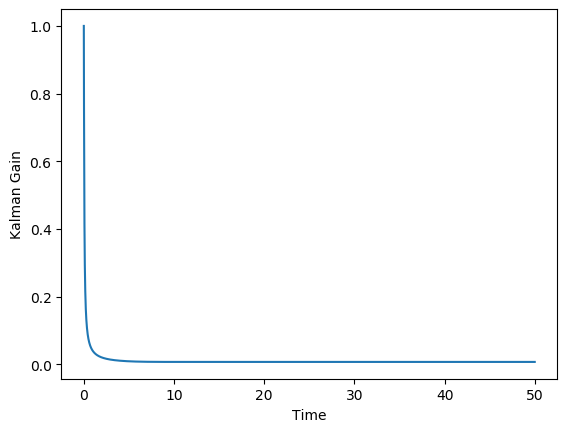

In [175]:
plt.plot(t[:5000], Kalman_Gain[:5000])

plt.xlabel('Time')
plt.ylabel('Kalman Gain')

plt.savefig('KG1.png', transparent=True)

plt.show()

## RMS

In [176]:
error = []

for i in range(len(t)):
    
    xp = Position[i]           #predicted height value
    xa = hTrue[i]           #true height value
    
    e = xa - xp                #estimation error
    e2 = e**2
    
    error.append(e2)

In [177]:
RMS = np.sqrt(sum(error)/len(error))   #root mean squared of the estimation error

print(RMS)

0.3538495154657323


In [178]:
error = []

for i in range(len(t)):
    
    xp = baroMeasure[i]           #predicted height value
    xa = hTrue[i]           #true height value
    
    e = xa - xp                #estimation error
    e2 = e**2
    
    error.append(e2)

In [179]:
RMS = np.sqrt(sum(error)/len(error))   #root mean squared of the estimation error

print(RMS)

0.3582190288280005


## Part 2

## Initial variables

In [180]:
T = 0.01                               #Time step between measurements

xo = [[0],                             #initial System State guess
     [0],
     [0.4]]

po = [[100, 0, 0],                      #initial uncertainty estimate guess
      [0, 100, 0],
     [0, 0, 100]]

F = [[1, T, 0],                           #State transition matrix
    [0, 1, 0],
    [0, 0, 1]]

H = [[1, 0, 1]]                           #Observation matrix

Qo = [[(T**4)/4, (T**3)/2, 0],    #Process noise matrix
      [(T**3)/2, T**2, 0],
      [0, 0, 0]]

Q = np.dot(Qo, (ϵacceleration*T)**2)

rn = [[σbarometer**2]]                  #Measurement uncertainty

I = [[1, 0, 0],                         #Identity matrix
    [0, 1, 0],
    [0, 0, 1]]

B = [[0.5 * (T**2)],                    #Control matrix
    [T],
    [0]]

u0 = 0                                  #initial acceleration

In [181]:
Position = []
Velocity = []
Kalman_Gain = []

xo = state_extrap(F, xo, B, u0)
po = cov_extrap(F, po, Q)

for i in range(len(hTrue)):
    
    zn = baroMeasure[i]
    u = accMeasure[i]
    
    un = u + σacceleration**2

    Kn = gain(po, H, rn)
    Kalman_Gain.append(Kn[0].item())
    
    x = state_update(xo, Kn, zn, H)
    p = cov_update(I, Kn, H, po, rn)
        
    xo = state_extrap(F, x, B, un)
    po = cov_extrap(F, p, Q)
    
    Position.append(xo[0].item())
    Velocity.append(xo[1].item())

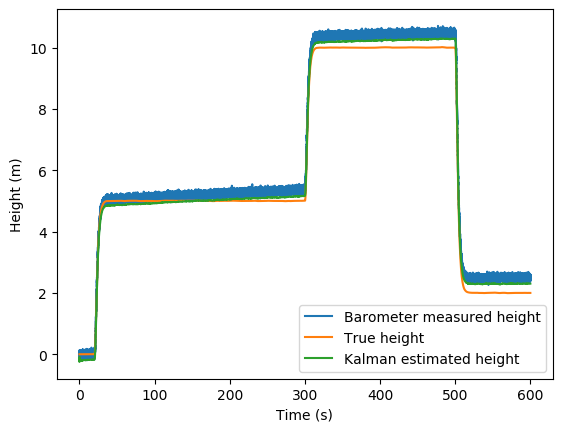

In [182]:
plt.plot(t, baroMeasure, label='Barometer measured height')
plt.plot(t, hTrue, label='True height')
plt.plot(t, Position, label='Kalman estimated height')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.savefig('Q1 part 2 height.png', transparent=True)

plt.show()

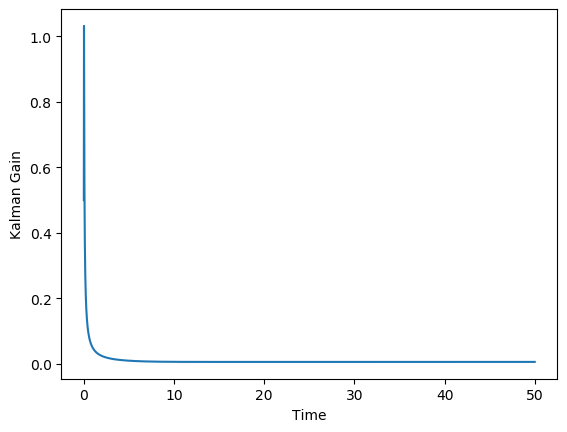

In [183]:
plt.plot(t[:5000], Kalman_Gain[:5000])

plt.xlabel('Time')
plt.ylabel('Kalman Gain')

plt.savefig('KG1 part 2.png', transparent=True)

plt.show()

## RMS

In [184]:
error = []

for i in range(len(t)):
    
    xp = Position[i]           #predicted height value
    xa = hTrue[i]           #true height value
    
    e = xa - xp                #estimation error
    e2 = e**2
    
    error.append(e2)

In [185]:
RMS = np.sqrt(sum(error)/len(error))   #root mean squared of the estimation error

print(RMS)

0.1943229036841408


# Question 2

## functions

In [186]:
def state_extrap(F, xo, B, u):
    
    x = np.dot(F, xo) + np.dot(B, u)
    
    return x

In [187]:
def cov_extrap(F, p, Q):
    
    p = np.dot(np.dot(F, p), np.transpose(F)) + Q
    
    return p

In [188]:
def gain(po, H, rn):
    
    Kn = np.dot(np.dot(po, np.transpose(H)),np.linalg.inv((np.dot(np.dot(H , po), np.transpose(H)) + rn)))
    
    return Kn

In [189]:
def state_update(xo, Kn, zn, H):
    
    xn = xo + np.dot(Kn, (zn - np.dot(H, xo)))
    
    return xn

In [190]:
def cov_update(I, Kn, H, po, rn):
    
    pn = np.dot(np.dot((I - np.dot(Kn,H)),po),np.transpose(I - np.dot(Kn,H))) + np.dot(np.dot(Kn, rn), np.transpose(Kn))
    
    return pn

## Initialise variables

In [191]:
σsonar = 0.02
σbarometer = 0.056 
σacceleration = 0.003
ϵacceleration = 1.25

In [192]:
T = 0.01                               #Time step between measurements

xo = [[0],                             #initial System State guess
     [0],
     [0.4]]

po = [[100, 0, 0],                      #initial uncertainty estimate guess
      [0, 100, 0],
     [0, 0, 100]]

F = [[1, T, 0],                         #State transition matrix
    [0, 1, 0],
    [0, 0, 1]]

H = [[1, 0, 1],
    [1, 0, 0]]                           #Observation matrix

Qo = [[(T**4)/4, (T**3)/2, 0],    #Process noise matrix
      [(T**3)/2, T**2, 0],
      [0, 0, 0]]

Q = np.dot(Qo, (ϵacceleration*T)**2)

rn = [[σbarometer**2, 0],
     [0, σsonar**2]]                     #Measurement uncertainty

I = [[1, 0, 0],                          #Identity matrix
    [0, 1, 0],
    [0, 0, 1]]

B = [[0.5 * (T**2)],                    #Control matrix
    [T],
    [0]]

u0 = 0                                  #initial acceleration

## General code

In [193]:
Position = []
Velocity = []
Kalman_Gain = []
Kalman_Gain2 = []

xo = state_extrap(F, xo, B, u0)
po = cov_extrap(F, po, Q)

for i in range(len(hTrue)):
    
    zn = [[baroMeasure[i]],
          [sonarMeasure[i]]]
          
    u = accMeasure[i]
    un = u + σacceleration**2

    Kn = gain(po, H, rn)
    Kalman_Gain.append(Kn[0][0].item())
    #print(Kn)
    Kalman_Gain2.append(Kn[1][1].item())
    
    x = state_update(xo, Kn, zn, H)
    p = cov_update(I, Kn, H, po, rn)
        
    xo = state_extrap(F, x, B, un)
    po = cov_extrap(F, p, Q)
    
    Position.append(xo[0].item())
    Velocity.append(xo[1].item())

## Graphs

C:\Users\F5331811\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.


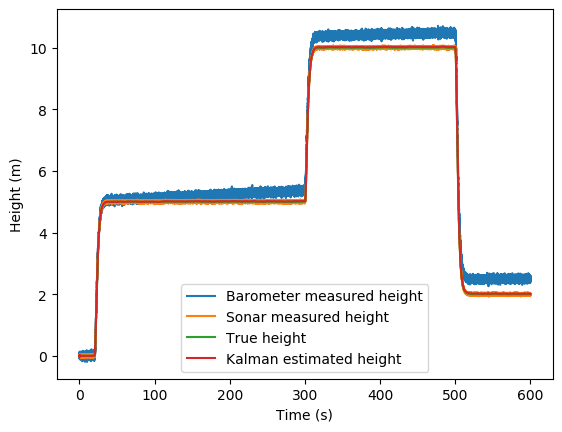

In [194]:
plt.plot(t, baroMeasure, label='Barometer measured height')
plt.plot(t, sonarMeasure, label='Sonar measured height')
plt.plot(t, hTrue, label='True height')
plt.plot(t, Position, label='Kalman estimated height')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.savefig('Q2 height.png', transparent=True)

plt.show()

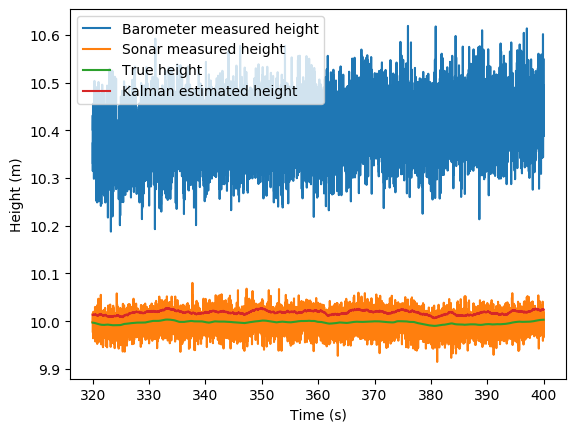

In [195]:
plt.plot(t[32000:40000], baroMeasure[32000:40000], label='Barometer measured height')
plt.plot(t[32000:40000], sonarMeasure[32000:40000], label='Sonar measured height')
plt.plot(t[32000:40000], hTrue[32000:40000], label='True height')
plt.plot(t[32000:40000], Position[32000:40000], label='Kalman estimated height')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.savefig('Q2 height zoomed.png', transparent=True)

plt.show()

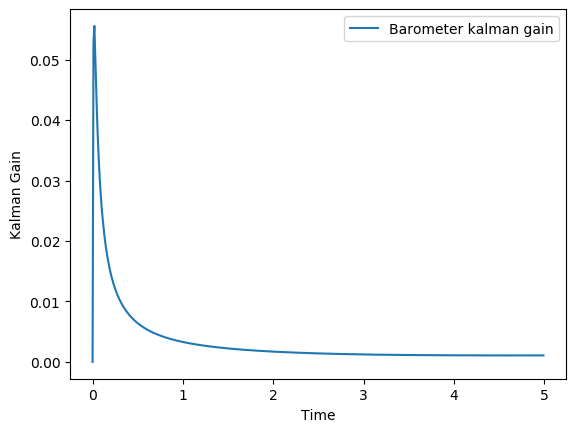

In [203]:
#plt.plot(t[:500], Kalman_Gain2[:500], label='Sonar kalman gain')
plt.plot(t[:500], Kalman_Gain[:500], label='Barometer kalman gain')


plt.xlabel('Time')
plt.ylabel('Kalman Gain')

plt.legend()

plt.savefig('KG2.png', transparent=True)

plt.show()

## RMS

In [197]:
error = []

for i in range(len(t)):
    
    xp = Position[i]           #predicted height value
    xa = hTrue[i]           #true height value
    
    e = xa - xp                #estimation error
    e2 = e**2
    
    error.append(e2)

In [198]:
RMS = np.sqrt(sum(error)/len(error))   #root mean squared of the estimation error

print(RMS)

0.017570992152610744
